<a href="https://colab.research.google.com/github/IyadSultan/AI_pediatric_oncology/blob/main/07_training_a_vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is a modificiaiton of Jacob Labur notebook but using pytorch

🩺 0 | Install & Imports

In [ ]:
# %%capture
!pip install -q opendatasets torch torchvision torcheval scikit-learn tqdm


In [ ]:
import opendatasets as od, pathlib, os, time, json, math
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score)
print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch: 2.6.0+cu124


| Piece | Reason |
|-------|--------|
| **torch / torchvision** | Core DL + ready-made MobileNetV2 |
| **torcheval** | (optional) more metrics |
| **scikit-learn** | ROC, PR, confusion-matrix |
| `device`        | auto-GPU switch |

1 | Download Chest-Xray-Pneumonia Dataset

In [ ]:
url = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"
od.download(url, force=True)           # prompts for Kaggle creds if not set
root = pathlib.Path("chest-xray-pneumonia/chest_xray")
train_dir, val_dir, test_dir = [root/p for p in ["train", "val", "test"]]
print("Data ready at:", root)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iyadsultan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:19<00:00, 124MB/s]



Data ready at: chest-xray-pneumonia/chest_xray


2 | Transforms & DataLoaders
Key idea: Resize to
128
×
128
128×128, apply random augments only on training, convert to tensor & normalize using ImageNet mean/std (MobileNetV2 was pre-trained there).

In [ ]:
IMG_SIZE = 128
BATCH = 32

# ImageNet mean and std for normalization (used with pre-trained models)
imgnet_mean = (0.485, 0.456, 0.406)
imgnet_std = (0.229, 0.224, 0.225)

# Standard validation/test transforms (no augmentation)
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std),
])

from PIL import Image

# Normal class transforms (standard augmentation)
normal_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std),
])

# Pneumonia class transforms (more aggressive augmentation)
# This helps improve recall by creating more diverse pneumonia training examples
pneumonia_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.7),  # Higher flip probability
    transforms.RandomRotation(20),           # More rotation variation
    transforms.RandomAffine(0, shear=15, scale=(0.85,1.15)),  # More deformation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),     # Add color variation
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std),
])

# Custom dataset that applies different transforms based on class label
class CustomChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, normal_transform, pneumonia_transform):
        self.root_dir = root_dir
        self.normal_transform = normal_transform
        self.pneumonia_transform = pneumonia_transform

        self.samples = []
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
        self.targets = []  # For compatibility with weighted sampler later

        # Collect all samples
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpeg', '.jpg', '.png')):
                    label = self.class_to_idx[cls]
                    self.samples.append((os.path.join(class_dir, filename), label))
                    self.targets.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        # Apply class-specific transforms
        if label == 0:  # NORMAL
            img = self.normal_transform(img)
        else:  # PNEUMONIA
            img = self.pneumonia_transform(img)

        return img, label

# Create datasets with class-specific augmentation for training
train_ds = CustomChestXrayDataset(train_dir, normal_tfms, pneumonia_tfms)
# Regular datasets for validation and testing (no augmentation)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)
test_ds = datasets.ImageFolder(test_dir, transform=val_tfms)

# Create weighted sampler to oversample pneumonia cases, improving recall
targets = train_ds.targets
class_sample_count = [targets.count(0), targets.count(1)]  # Count of normal and pneumonia
print(f"Class distribution - Normal: {class_sample_count[0]}, Pneumonia: {class_sample_count[1]}")

# Assign weights to make pneumonia samples more likely to be selected
weights = [1.0/class_sample_count[0] if t == 0 else 3.0/class_sample_count[1] for t in targets]  # Increased weight for pneumonia
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

# Use the weighted sampler for training to focus more on pneumonia cases
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

class_names = val_ds.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

Class distribution - Normal: 1341, Pneumonia: 3875
Classes: ['NORMAL', 'PNEUMONIA']


3 | Peek at a Few Images (optional)
python
Copy
Edit


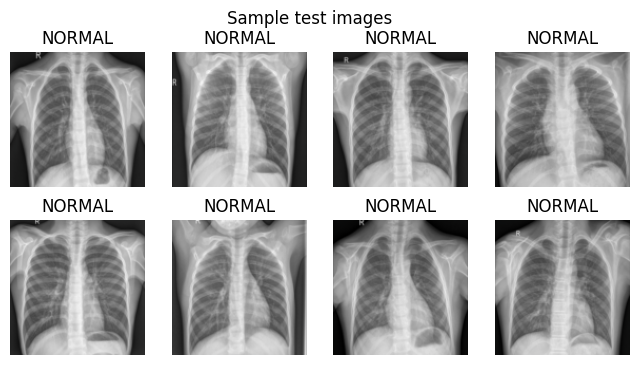

In [ ]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1,2,0))*np.array(imgnet_std)+np.array(imgnet_mean)
    plt.imshow(np.clip(inp,0,1)); plt.axis('off');
    if title: plt.title(title)

batch = next(iter(test_loader))
plt.figure(figsize=(8,4))
for i,(img,label) in enumerate(zip(*batch)):
    if i==8: break
    plt.subplot(2,4,i+1)
    imshow(img); plt.title(class_names[label])
plt.suptitle("Sample test images"); plt.show()


4 | Build Transfer-Learning Model

In [ ]:
# Use EfficientNet instead of MobileNetV2 for better feature extraction
base = models.efficientnet_b0(weights="IMAGENET1K_V1")
base.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Slightly higher dropout for regularization
    nn.Linear(base.classifier[1].in_features, 1)  # Binary classification
)
model = base.to(device)

# Freeze feature extractor for phase-1
for p in base.parameters():
    p.requires_grad_(False)

# Unfreeze only the classifier
for p in base.classifier.parameters():
    p.requires_grad_(True)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Higher alpha gives more weight to pneumonia class
        self.gamma = gamma  # Focuses on hard examples

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

# Use Focal Loss to focus on hard-to-classify pneumonia cases
criterion = FocalLoss(alpha=0.75, gamma=2.0)

# Start with a higher learning rate for the initial training
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 48.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


5 | Train Head (Phase-1)

In [ ]:
# Calculate weight for positive class (pneumonia)
pos_count = sum(y == 1 for _, y in train_ds)
neg_count = sum(y == 0 for _, y in train_ds)
pos_weight = torch.tensor([neg_count/pos_count], device=device)

# Use weighted BCE loss to focus more on pneumonia cases
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)



optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

def train_one_epoch(loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.float().to(device).unsqueeze(1)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        # Calculate accuracy
        predicted = torch.sigmoid(outputs) >= 0.5
        total += y.size(0)
        correct += (predicted == y).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.float().to(device).unsqueeze(1)

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) >= 0.5
            total += y.size(0)
            correct += (predicted == y).sum().item()

    val_loss = running_loss / len(loader.dataset)
    val_acc = correct / total

    return val_loss, val_acc

# Training parameters
EPOCHS1 = 3  # Initial training epochs
EPOCHS2 = 8  # Fine-tuning epochs
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Phase 1: Train only the classifier
print("Phase 1: Training classifier layers")
for epoch in range(EPOCHS1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    # Step the scheduler
    scheduler.step(val_loss)

    # Print metrics
    print(f"Epoch {epoch+1}/{EPOCHS1}  train_loss: {train_loss:.4f}  train_acc: {train_acc:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  LR: {optimizer.param_groups[0]['lr']:.6f}  ({time.time()-t0:.1f}s)")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model_phase1.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Phase 2: Fine-tune with unfrozen feature extractor layers
# Load best model from phase 1
model.load_state_dict(torch.load('best_model_phase1.pth'))

# Unfreeze features from index 5 onwards (about 2/3 of the network)
for i, layer in enumerate(base.features):
    if i >= 5:  # Unfreeze more layers for better feature adaptation
        for param in layer.parameters():
            param.requires_grad_(True)

# Reset optimizer with lower learning rate for fine-tuning
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=5e-5, weight_decay=2e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True
)

# Reset early stopping variables
best_val_loss = float('inf')
patience_counter = 0

print("\nPhase 2: Fine-tuning feature extractor layers")
for epoch in range(EPOCHS2):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    # Step the scheduler
    scheduler.step(val_loss)

    # Print metrics
    print(f"Epoch {epoch+1}/{EPOCHS2}  train_loss: {train_loss:.4f}  train_acc: {train_acc:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  LR: {optimizer.param_groups[0]['lr']:.6f}  ({time.time()-t0:.1f}s)")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model_phase2.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model for evaluation
model.load_state_dict(torch.load('best_model_phase2.pth'))


Phase 1: Training classifier layers
Epoch 1/3  train_loss: 0.1854  train_acc: 0.8574  val_loss: 0.3534  val_acc: 0.5000  LR: 0.001000  (72.5s)
Epoch 2/3  train_loss: 0.1243  train_acc: 0.8982  val_loss: 0.3614  val_acc: 0.5000  LR: 0.001000  (73.3s)
Epoch 3/3  train_loss: 0.1235  train_acc: 0.8974  val_loss: 0.3836  val_acc: 0.6875  LR: 0.001000  (72.7s)

Phase 2: Fine-tuning feature extractor layers
Epoch 1/8  train_loss: 0.0940  train_acc: 0.9247  val_loss: 0.2588  val_acc: 0.7500  LR: 0.000050  (74.3s)
Epoch 2/8  train_loss: 0.0557  train_acc: 0.9586  val_loss: 0.2845  val_acc: 0.6875  LR: 0.000050  (75.5s)
Epoch 3/8  train_loss: 0.0484  train_acc: 0.9626  val_loss: 0.2487  val_acc: 0.8125  LR: 0.000050  (73.4s)
Epoch 4/8  train_loss: 0.0416  train_acc: 0.9695  val_loss: 0.2238  val_acc: 0.8125  LR: 0.000050  (74.8s)
Epoch 5/8  train_loss: 0.0353  train_acc: 0.9745  val_loss: 0.2447  val_acc: 0.8125  LR: 0.000050  (75.3s)
Epoch 6/8  train_loss: 0.0359  train_acc: 0.9734  val_loss: 0

<All keys matched successfully>

7 | Evaluate on Test Set

Evaluating model on test set...

Metrics at different thresholds:
Threshold  Accuracy   Precision  Recall    
----------------------------------------
0.50       0.8942     0.9286     0.9000    
0.40       0.8910     0.9128     0.9128    
0.30       0.9087     0.9111     0.9462    
0.20       0.9103     0.8957     0.9692    

Optimal threshold for F2 score: 0.12
At this threshold - Accuracy: 0.9054, Precision: 0.8858, Recall: 0.9744, F2 Score: 0.9553


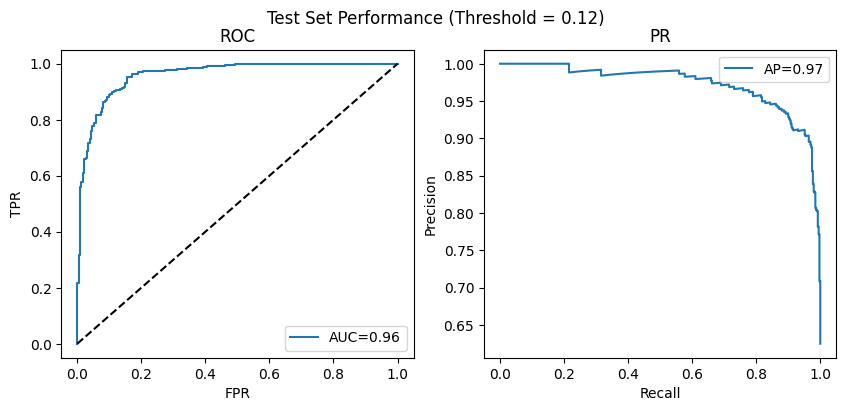

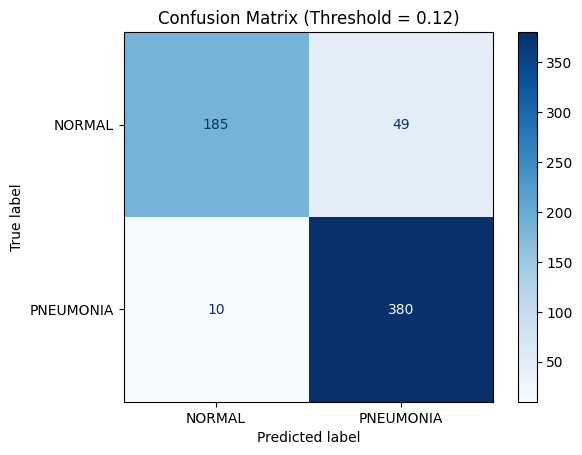


False Negatives (missed pneumonia cases): 10
Percentage of pneumonia cases missed: 2.56%

Metrics at standard threshold (0.5):
Accuracy : 0.8942
Precision: 0.9286
Recall   : 0.9000


In [ ]:
def get_preds(loader):
    model.eval()
    probs, y_true = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X).flatten()
            probs.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(y.numpy())
    return np.array(probs), np.array(y_true)

print("Evaluating model on test set...")
probs, y_true = get_preds(test_loader)

# Try different thresholds to optimize for recall
thresholds = [0.5, 0.4, 0.3, 0.2]
print("\nMetrics at different thresholds:")
print("{:<10} {:<10} {:<10} {:<10}".format("Threshold", "Accuracy", "Precision", "Recall"))
print("-" * 40)

for threshold in thresholds:
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print("{:<10.2f} {:<10.4f} {:<10.4f} {:<10.4f}".format(threshold, acc, prec, rec))

# Find optimal threshold for F2 score (weights recall higher than precision)
from sklearn.metrics import fbeta_score

best_threshold = 0
best_f2 = 0
best_metrics = None

for threshold in np.arange(0.1, 0.6, 0.02):
    y_pred = (probs >= threshold).astype(int)
    f2 = fbeta_score(y_true, y_pred, beta=2)  # F2 score weights recall higher
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold
        best_metrics = (acc, prec, rec, f2)

print(f"\nOptimal threshold for F2 score: {best_threshold:.2f}")
print(f"At this threshold - Accuracy: {best_metrics[0]:.4f}, Precision: {best_metrics[1]:.4f}, Recall: {best_metrics[2]:.4f}, F2 Score: {best_metrics[3]:.4f}")

# Use the best threshold for final prediction
y_pred_optimal = (probs >= best_threshold).astype(int)

# Plot ROC and PR curves
def plot_roc_pr(y_true, probs, title):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}"); ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set(xlabel='FPR', ylabel='TPR', title='ROC'); ax[0].legend()
    ax[1].plot(rec, prec, label=f"AP={ap:.2f}")
    ax[1].set(xlabel='Recall', ylabel='Precision', title='PR'); ax[1].legend()
    plt.suptitle(title); plt.show()

plot_roc_pr(y_true, probs, f"Test Set Performance (Threshold = {best_threshold:.2f})")

# Plot confusion matrix with optimal threshold
cm = confusion_matrix(y_true, y_pred_optimal)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.2f})")
plt.show()

# Calculate and display the number of false negatives
false_negatives = cm[1][0]
print(f"\nFalse Negatives (missed pneumonia cases): {false_negatives}")
print(f"Percentage of pneumonia cases missed: {false_negatives / np.sum(cm[1]) * 100:.2f}%")

# Standard metrics at 0.5 threshold for comparison with original model
y_pred = (probs >= 0.5).astype(int)
print("\nMetrics at standard threshold (0.5):")
print("Accuracy : {:.4f}".format(accuracy_score(y_true, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_true, y_pred)))
print("Recall   : {:.4f}".format(recall_score(y_true, y_pred)))

metrics + plots

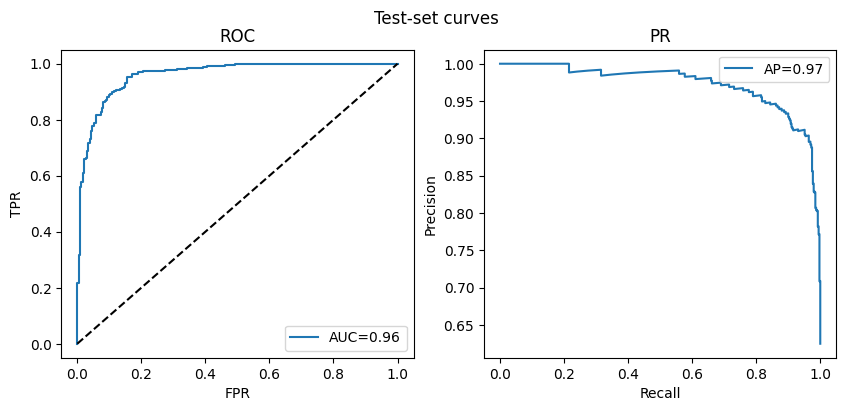

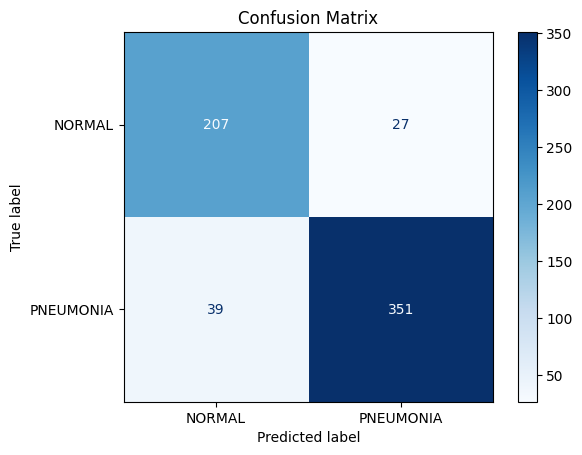

Accuracy : 0.8942
Precision: 0.9286
Recall   : 0.9000


In [ ]:
def plot_roc_pr(y_true, probs, title):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}"); ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set(xlabel='FPR', ylabel='TPR', title='ROC'); ax[0].legend()
    ax[1].plot(rec, prec, label=f"AP={ap:.2f}")
    ax[1].set(xlabel='Recall', ylabel='Precision', title='PR'); ax[1].legend()
    plt.suptitle(title); plt.show()

plot_roc_pr(y_true, probs, "Test-set curves")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix"); plt.show()

print("Accuracy : {:.4f}".format(accuracy_score(y_true, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_true, y_pred)))
print("Recall   : {:.4f}".format(recall_score(y_true, y_pred)))

8 | Educational Takeaways
Topic	Key lesson
Transfer-learning	Freeze → train head → un-freeze top layers with small LR for a big accuracy jump.
Data augmentation	Random flips/rotations add invariance (but never on validation/test).
BCEWithLogitsLoss	Combines sigmoid + BCE → stable, no need for explicit sigmoid in model.
Evaluation beyond accuracy	ROC, PR, confusion matrix reveal imbalanced-class pitfalls.
Threshold tuning	0.5 is default; in medicine you might pick threshold for target sensitivity (recall).
GPU vs CPU	device switching is trivial; bigger images/models may need torch.cuda.amp mixed precision.
Reproducibility	Low epochs in demo; dial up for real training. Seed random libs (torch.manual_seed).

 Next Steps
Swap MobileNetV2 for EfficientNet_B0 (torchvision.models.efficientnet_b0) for a minor accuracy boost.

Add learning-rate scheduler (torch.optim.lr_scheduler.CosineAnnealingLR).

Push metrics to Weights & Biases or TensorBoard for live tracking.

Export to TorchServe or ONNX for deployment in clinical image viewer apps.